# Import dependencies and determine working directory

In [1]:
# Import libraries
import numpy as np
from os import path
import cv2
import matplotlib.pyplot as plt
import math

In [2]:
# get current directory
dir = path.dirname(path.abspath('__file__'))

In [3]:
# load cascade classifiers https://github.com/opencv/opencv/tree/master/data/haarcascades
face_cascade_path = path.join(dir,'..','02_pretrained_models', 'haarcascade_frontalface_default.xml')
left_eye_cascade_path = path.join(dir,'..','02_pretrained_models', 'haarcascade_lefteye_2splits.xml')
right_eye_cascade_path = path.join(dir,'..','02_pretrained_models', 'haarcascade_righteye_2splits.xml')

face_cascade = cv2.CascadeClassifier(face_cascade_path)
left_eye_cascade = cv2.CascadeClassifier(left_eye_cascade_path)
right_eye_cascade = cv2.CascadeClassifier(right_eye_cascade_path)

In [4]:
# Convert image to colour
def convertToRGB(img): 
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Convert image to greyscale
def convertToGray(img): 
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [5]:
def identify_head(imagePath):
    # Read the image
    image = cv2.imread(imagePath)

    # Convert to gray
    gray = convertToGray(image)
    
    # detect face
    faces = face_cascade.detectMultiScale(
        gray,
        scaleFactor= 1.1,
        minNeighbors=5,
        flags = cv2.CASCADE_SCALE_IMAGE
    )
    
    # draw a rectangle around the face
    for (x, y, w, h) in faces:
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
    
    # show image 
    plt.imshow(convertToRGB(image))
    plt.show()
    
    # extract the face 
    (x, y, w, h) = faces[0]
    head = image[y:y + h, x:x + w]
    
    return head

In [6]:
def process_face(head):
    # define search areas 
    head_height, head_width = head.shape[:2]
    top_eye_edge = math.floor(0.1*head_height)
    bottom_eye_edge = math.floor(0.6*head_height)
    left_eye_edge = math.floor(0.1*head_width)
    center_edge = math.floor(0.5*head_width)
    right_eye_edge = math.floor(0.9*head_width)
    left_eye_area = head[top_eye_edge:bottom_eye_edge, left_eye_edge:center_edge]
    right_eye_area = head[top_eye_edge:bottom_eye_edge, center_edge:right_eye_edge]
    
    # define fixed parameters for scaling 
    desired_left_eye = (0.25, 0.25)
    desired_face_width = 200
    desired_face_height = desired_face_width
    
    # Instantiate variables
    left_eye_middle = None
    right_eye_middle = None
    
    # Locate eyes
    left_eye = left_eye_cascade.detectMultiScale(left_eye_area, scaleFactor=1.1, minNeighbors=2)
    right_eye = right_eye_cascade.detectMultiScale(right_eye_area, scaleFactor=1.1, minNeighbors=2)
    
    # Find the middle of the left and right eyes
    if left_eye is () or right_eye is ():
        return  head
    else: 
        for (x_left, y_left, w_left, h_left) in left_eye:
            left_eye_middle = np.array([ left_eye_edge + x_left + w_left / 2, top_eye_edge + y_left + h_left / 2])

        for (x_right, y_right, w_right, h_right) in right_eye:
            right_eye_middle = np.array([center_edge + x_right + w_right / 2, top_eye_edge + y_right + h_right / 2])
            
        # Find the middle point between the eyes
        eye_middle = (left_eye_middle + right_eye_middle) / 2

        # Find the angle of the eye line 
        eye_angle_rad = np.arctan2(right_eye_middle[1] - left_eye_middle[1], right_eye_middle[0] - left_eye_middle[0]) 
        eye_angle_deg = eye_angle_rad * 180.0 / math.pi
        
        # Find the scaling factor
        face_scale_factor = (1.0 - desired_left_eye[0] * 2) * desired_face_width / np.linalg.norm(right_eye_middle - left_eye_middle)
        
        # Set up rotation and scaling matrix 
        transformation_mat = cv2.getRotationMatrix2D(tuple(eye_middle), eye_angle_deg, face_scale_factor)

        # Center matrix around the center of the eyes
        transformation_mat[0,2] += desired_face_width * 0.5 - eye_middle[0]
        transformation_mat[1,2] += desired_left_eye[1] * desired_face_height - eye_middle[1]
        
        # Adjust image
        adjusted_face = cv2.warpAffine(head, transformation_mat, (desired_face_width, desired_face_height))
        
        return adjusted_face

In [7]:
def process_image(inputPath, outputPath):
    head = identify_head(inputPath)
    adjusted_face = process_face(head)
    cv2.imwrite(outputPath, convertToGray(adjusted_face) )
    plt.imshow(convertToRGB(adjusted_face))
    plt.show()

In [8]:
# get image path
# imagePath = path.join(dir,'..','01_raw_data', 'CelebA', 'Img', 'img_celeba.7z', 'img_celeba', '000140.jpg')
# imagePath = path.join(dir,'..','01_raw_data', 'jaffe', 'KA.AN1.39.tiff')
imagePath = path.join(dir,'..','01_raw_data', 'Portraits', 'image_12.png')

outputPath = path.join(dir,'..','03_processed_images', 'image_01.jpg')

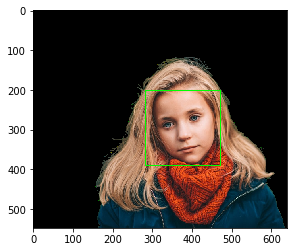

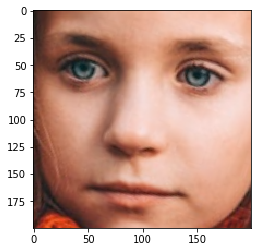

In [9]:
process_image(imagePath, outputPath)

# To be deleted

In [ ]:
# extract the left eye 
for (x_l_eye, y_l_eye, w_l_eye, h_l_eye) in left_eye:
    left_eye_extract = head[top_eye_edge + y_l_eye : top_eye_edge + y_l_eye + h_l_eye, 
                            left_eye_edge + x_l_eye: left_eye_edge + x_l_eye + w_l_eye]

plt.imshow(left_eye_extract)
plt.show()

# extract the right 
for (x_r_eye, y_r_eye, w_r_eye, h_r_eye) in right_eye:
    right_eye_extract = head[top_eye_edge + y_r_eye : top_eye_edge + y_r_eye + h_r_eye, 
                             center_edge + x_r_eye : center_edge + x_r_eye + w_r_eye]

plt.imshow(right_eye_extract)
plt.show()